In [6]:
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as rt
import onnx
import pandas as pd

from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing
from constants import protected_attributes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Metamorphic testing class (works with pre-trained onnx models)

Helper Functions for metapmorphic testing

In [7]:
from onnxruntime.capi.onnxruntime_pybind11_state import InvalidArgument

def test_metamorphic(data, feature_name : str, is_Fraud: bool ,value_from : int, value_to: int, model_path : str):
    data_modified = data.copy() 
    is_checked = 1 if is_Fraud else 0
    test_data= data_modified.loc[data_modified['checked'] == is_checked]
    test_data = test_data.loc[test_data[feature_name] == value_from]
    data_wout = test_data.copy()
    y_wout = data_wout['checked']
    X_wout= data_wout.drop(['checked'], axis=1)
    X_wout = X_wout.astype(np.float32)
    test_data[feature_name] = value_to
    y_test = test_data['checked']
    X_test= test_data.drop(['checked'], axis=1)
    X_test = X_test.astype(np.float32)
    session = rt.InferenceSession(model_path)
        
    try:
        y_pred_onnx1 =  session.run(None, {'X': X_wout.values.astype(np.float32)})
        y_pred_onnx2 =  session.run(None, {'X': X_test.values.astype(np.float32)})
        y_pred_onnx1_np = np.array(y_pred_onnx1[0])
        y_pred_onnx2_np = np.array(y_pred_onnx2[0])
        diff_count = np.sum(y_pred_onnx1_np != y_pred_onnx2_np)
        return diff_count, len(y_pred_onnx1_np)
    except InvalidArgument:
        #print("Got error: empty test dataframe. " "Column is: ", feature_name, " combo is:", is_Fraud, value_from, value_to)
        return 0, 0
    # assert y_pred_onnx1[0].all() == y_pred_onnx2[0].all(), f'Model predictions are different. The model has bias towards {feature_name} with value {value_from} '
    # return True

def plot_metamorphic_results(pre_trained_models):
    data = []
    for model in pre_trained_models:
        # Extract the percentage (it's the 2nd tuple value) and multiply it with 100
        data.append([tup[1]*100 for tup in model.column_avg])
    
    plt.boxplot(data)
    # Add title and labels
    plt.title('Box Plot of Arrays')
    plt.xlabel('Arrays')
    plt.ylabel('Values')

    # Show the plot
    plt.show()

Making a class that tests all combinations of feature values in metamorphic testing

In [8]:
class MetamorphicTester:
    def __init__(self, data_path, model_path):
        self.model = model_path
        self.df = pd.read_csv(data_path)
        self.mutation_test_results = {}
        self.column_avg = None
        self.global_average = None
        
    def test(self):
        # Iterate over each column in the DataFrame and generate the mutation test combinations
        for column in self.df.columns:
            # Get unique values for the current column
            unique_values = self.df[column].unique()
            if len(unique_values) > 1:
                # We sample two random values from the unique options, and store this in the dictionary
                rand_values = np.random.choice(unique_values, size=2, replace=False)
                combos = []
                for bool in [True, False]:
                    for a in rand_values:
                        for b in rand_values:
                            combos.append([bool, a, b])
                
                self.mutation_test_results[column] = combos
        
        # Go over each combination and get how many tests failed to kill the mutation
        for column, values in self.mutation_test_results.items():
            for combo in values:
                num_differ, length = test_metamorphic(self.df, column, combo[0], combo[1], combo[2], self.model)
                combo.append(num_differ)
                combo.append(length)
    
    def analyse_test(self):
        # We can now do some basic data analysis.
        # We can compute a score on a per-column basis, getting an average across 8 tests of what percentage of mutants were failed to kill
        # We can also compute a sort of global metric. Just an average across all mutations
        column_avg = []
        all_percentages = []
        
        for column, values in self.mutation_test_results.items():
            percentages = []
            for combo in values:
                # compute percentage, and add it to a temp array to compute the average value
                if combo[4] != 0:
                    res = combo[3]/combo[4]
                    percentages.append(res)
                    all_percentages.append(res)
            column_avg.append((column, np.mean(np.array(percentages))))
        
        column_avg = sorted(column_avg, key=lambda x: x[1], reverse=True)
        
        # Save the results
        self.column_avg = column_avg
        self.global_average = np.mean(np.array(all_percentages)) * 100

# features_to_ignore = ["adres_dagen_op_adres", "afspraak_aantal_woorden", "afspraak_laatstejaar_aantal_woorden", "belemmering_dagen_financiele_problemen", 
#                       "belemmering_dagen_lichamelijke_problematiek", "belemmering_dagen_psychische_problemen", "contacten_onderwerp_overige", "contacten_onderwerp_terugbelverzoek", "contacten_onderwerp_traject", "contacten_soort_afgelopenjaar_document__uitgaand_", 
#                       "contacten_soort_document__inkomend_", "contacten_soort_document__uitgaand_", "contacten_soort_e_mail__inkomend_", "contacten_soort_e_mail__uitgaand_", "contacten_soort_telefoontje__inkomend_", "contacten_soort_telefoontje__uitgaand_", 
#                       "deelname_act_reintegratieladder_werk_re_integratie", "ontheffing_dagen_hist_mean", "ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden", "persoon_leeftijd_bij_onderzoek", "persoonlijke_eigenschappen_dagen_sinds_opvoer", "persoonlijke_eigenschappen_dagen_sinds_taaleis", "persoonlijke_eigenschappen_spreektaal", "relatie_kind_leeftijd_verschil_ouder_eerste_kind", "typering_dagen_som"]



## Setting up a class to do mutation testing (requires training)

In [55]:
def mutation(key):
  def do_assignment(to_func):
    to_func.key = key
    return to_func
  return do_assignment


class MutationTester:
    def __init__(self, y_pred_baseline, df_train, df_test):
        self.y_pred_baseline = y_pred_baseline
        self.df_train = df_train
        self.df_test = df_test
    
    
    def test_mutants(self, params, n_mutants=5):
        
        mutants = [getattr(self, field) for field in dir(self) if hasattr(getattr(self, field), "key")]
        
        mutation_scores = {}
        
        for mutant in mutants:
            
                n_mutants_killed = 0

                for _ in n_mutants:
                    data = mutant(params[mutant.key])
                    X_train_mutant = data.iloc[:, :-1]
                    y_train_mutant = data.iloc[:, -1]
                    
                    mutant_model = GradientBoostingClassifier()
                    mutant_model.fit(X_train_mutant, y_train_mutant)
                    
                    X_test = self.df_test.iloc[:, :-1]
                    y_test = self.df_test.iloc[:, -1]
                    y_pred_mutant = mutant_model.predict(X_test)

                    """
                        REFERENCE: https://sci-hub.se/10.1109/icst46399.2020.00018
                        The mutation score metric in DeepMutation is defined only for classification systems. 
                        More specifically, in case of a kclassification problem with a set of classes C = {c1, ..., ck}, 
                        a test input t ∈ T kills the pair c, m, with class c ∈ C and mutant m ∈ M, 
                        if t is correctly classified as c by the original model and if t is misclassified by the mutant model m. 
                        Based on this, the mutation score is calculated as the ratio of killed classes per mutant m over the product of the sizes of M and C
                    """
                    killed = (y_pred_mutant == y_test) & (self.y_pred_baseline != y_test)
                    
                    n_mutants_killed += sum(killed)
                mutation_scores[mutant.key] = n_mutants_killed / (n_mutants * 2)
        
        return mutation_scores
                
    """
    The given training data is shuffled in a random order. Specifically, a random data point is swapped with another, 
    this is done equal to the iterations parameter number of times 
    """
    @mutation('data_shuffler')
    def data_shuffler(self, iterations=1000):
        shuffled_data = self.df_train.copy()
        num_rows = len(self.df_train)
        
        for i in range(iterations):
            # Choose two random indices for swapping
            idx1, idx2 = np.random.randint(0, num_rows, 2)
    
            # Swap rows at random two indices
            shuffled_data.iloc[idx1], shuffled_data.iloc[idx2] = (
                shuffled_data.iloc[idx2].copy(),
                shuffled_data.iloc[idx1].copy(),
            )
        return shuffled_data

    """
    A fixed percentage of the training data is removed (at random)
    """
    @mutation('data_remover')
    def data_remover(self, percent=0.1):
        # Calculate the number of rows to remove based on the percentage
        num_rows_to_remove = int(len(self.df_train) * percent)
        smaller_df = self.df_train.copy()
        return smaller_df.drop(smaller_df.sample(n=num_rows_to_remove).index)
    
    """
    Chosen randomly, the values of a row of the training data is replicated into another row. This is done
    iterations number of times
    """
    @mutation('data_repetition')
    def data_repetition(self, iterations=1000):
        repeated_data = self.df_train.copy()
        num_rows = len(self.df_train)
        
        for i in range(iterations):
            # Choose two random indices. The value of the first will be duplicated onto the 2nd
            idx1, idx2 = np.random.randint(0, num_rows, 2)
            repeated_data.iloc[idx2] = repeated_data.iloc[idx1].values
        return repeated_data
    
    @mutation('label_error')
    def label_error(self, num_rows=1000):
        assert num_rows < len(self.df_train), "Please chose to alter the labels of less training data"
        changed_data = self.df_train.copy()
        # Get the indices of rows that will have their labels changed
        rows_to_change = np.random.choice(self.df_train.index, num_rows, replace=False)
        
        # Change the values of the last column ("checked") for the randomly selected rows (0 becomes 1 and vice versa)
        changed_data.loc[rows_to_change, self.df_train.columns[-1]] = 1 - changed_data.loc[rows_to_change, self.df_train.columns[-1]]
        
        return changed_data

## Functional test class (can work with training or without)


In [35]:
class FunctionalTester:
    def __init__(self, model_path):
        self.model = model_path
    
    """
    Evaluates the model and returns performance metrics
    """
    def evaluate_model(self, X_test, y_test):
        session = rt.InferenceSession(self.model)
        y_pred = session.run(None, {'X': X_test.values.astype(np.float32)})   
        cm = confusion_matrix(y_test, y_pred[0])
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)  # False Positive Rate
        tnr = tn / (tn + fp)  # True Negative Rate
        npr = tp / (tp + fn)  # Negative Predictive Rate
        fnr = fn / (fn + tp)  # False Negative Rate
        precision = tp / (tp + fp)  # Precision
        recall = tp / (tp + fn)  # Recall
        f1 = 2 * (precision * recall) / (precision + recall)  # F1 Score
        
        return {
            "fpr": fpr,
            "tnr": tnr,
            "npr": npr,
            "fnr": fnr,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

## Test Cases

Doing some metamorphic testing

In [12]:
data = pd.read_csv("./../data/synth_data_for_training.csv")
model_path = "./../model/baseline_model.onnx"

In [13]:
t1 = test_metamorphic(data, "adres_aantal_brp_adres", True, 11, 11, model_path)
t2 = test_metamorphic(data, 'persoon_geslacht_vrouw', True, 0, 1, model_path) #test if changing gender of women who are frauds to men to see if predictions change to not fraud
t3 = test_metamorphic(data, 'persoon_geslacht_vrouw', False, 0, 1, model_path) #test if changing gender of men who are not frauds to women to see if predictions change to not fraud
t4 = test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', True, 0, 1, model_path) #test if changing non dutch speaker people who are frauds to dutch speaking to see if predictions change to not fraud
t5 = test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', False, 1, 0, model_path) #test if changing dutch speaker people who are not frauds to non-dutch speaking to see if predictions change to fraud
t6 = test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', True, 2, 1, model_path) #test if changing people who are frauds and did no take the dutch exam to dutch speaking to see if predictions change to not fraud
print(t1, t2, t3, t4, t5, t6)

(0, 0) (9, 663) (4, 5879) (14, 708) (3, 6558) (0, 104)


In [14]:
baseline = MetamorphicTester('./../data/synth_data_for_training.csv', './../model/baseline_model.onnx')
baseline.test()
baseline.analyse_test()

good_model = MetamorphicTester('./../data/synth_data_for_training.csv', './../model/good_model.onnx')
good_model.test()
good_model.analyse_test()

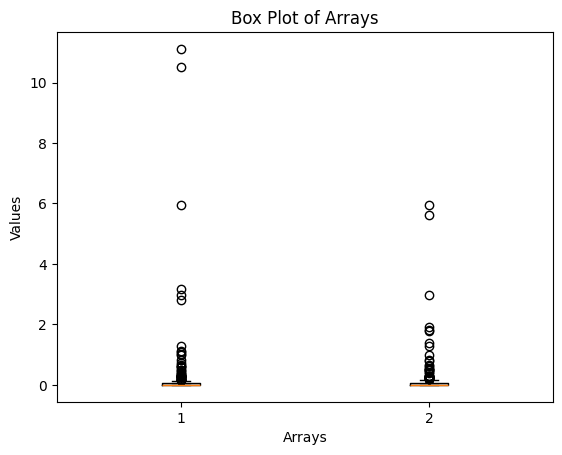

In [15]:
models = [baseline, good_model]
plot_metamorphic_results(models)

Doing some functional testing

In [21]:
data_copy = data.copy().astype(np.float32)
features = data_copy.columns[:-1]  # Exclude last column (target)
target = data_copy.columns[-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_copy[features], data_copy[target], test_size=0.2)

functional_tester = FunctionalTester("./../model/baseline_model.onnx")

functional_tester.evaluate_model(X_test, y_test)

{'fpr': 0.00175054704595186,
 'tnr': 0.9982494529540481,
 'npr': 0.9139344262295082,
 'fnr': 0.0860655737704918,
 'precision': 0.9823788546255506,
 'recall': 0.9139344262295082,
 'f1': 0.9469214437367303}

Doing some data mutating (will need to then train using this data and then call functional or metamorphic)

In [56]:

params = {
    'data_shuffler': 1000,
    'data_remover': 0.25,
    'data_repetition': 1000, 
    'label_error': 1000
}


df_train = pd.read_csv("./../data/train.csv")
df_test = pd.read_csv("./../data/test.csv")
session = rt.InferenceSession(functional_tester.model)

y_pred = session.run(None, {'X': df_test.iloc[:, :-1].values.astype(np.float32)})[0]

mutator = MutationTester(y_pred_baseline=y_pred, df_train=df_train, df_test=df_test)
mutation_score = mutator.test_mutants(params)
print(f"Mutation score: {mutation_score}")


Mutation score: 32.0


0.0
